In [3]:
from dotenv import load_dotenv
load_dotenv()
import random
random.seed(42)
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from experiments.classifier_experiments.experiment_utils import load_json_data
from experiments.article_annotation.article_labeling_using_chatgpt import load_raw_articles, get_templates, truncate_messages, generate_response

In [4]:
annotated_sections = load_json_data('../../data/')
annotated_categories = list(annotated_sections.label.unique())

raw_articles = load_raw_articles('../../data/raw_data.jsonl')
annotated_articles = [article for article in raw_articles if article['category'].lower() in [cat for cat in annotated_categories]]

Loaded: 3d_printed_clothes_sentences.jsonl
Loaded: cement_production_sentences.jsonl
Loaded: organic_food_sentences.jsonl
Loaded: shipping_sentences.jsonl
Loaded: sustainable_fabrics_sentences.jsonl
Loaded: artificial_intelligence_sentences.jsonl
Loaded: clothes_designed_for_a_circular_economy_sentences.jsonl
Loaded: autonomous_transport_sentences.jsonl
Loaded: fiber_optic_cables_sentences.jsonl
Loaded: electric_car_sentences.jsonl
Loaded: drone_sentences.jsonl
Loaded: e_health_sentences.jsonl
Loaded: capsule_wardrobe_sentences.jsonl
Loaded: car_sharing_sentences.jsonl
Loaded: smart_food_management_kitchen_fridges_freezers_sentences.jsonl
Loaded: biking_sentences.jsonl
Loaded: rent_apparel_sentences.jsonl


In [5]:
def classify_sections(sections, categories):
    invalid_responses = []
    predictions = []
    for idx, section in sections.iterrows():
        system_template, prompt_template = get_templates(categories, section.title, section.text)
        messages = [
            {"role":"system","content": system_template},
            {"role": "user", "content": prompt_template}
        ]
        messages, _ = truncate_messages(messages)
        response = generate_response(messages).strip().replace('.', '').lower()
        second_prediction = response
        if response not in annotated_categories + ['unsure','irrelevant']:
            invalid_responses.append(response)
            messages.append({"role": "assistant", "content": response})
            messages.append({"role": "user", "content": 'Your response is not valid. It does not match any of the provided categories, "unsure" or "irrelevant". Please try again.'})
            second_prediction = generate_response(messages).replace('.', '').lower()
        predictions.append({
            "section": section.text,
            "prediction": response,
            "second_prediction": second_prediction,
            "annotation": section.answer,
            "title": section.title
            })
    return predictions, invalid_responses

# Get Predictions

In [6]:
# example prompt
example_system_prompt, example_prompt = get_templates(annotated_categories, annotated_sections.iloc[0]["title"], annotated_sections.iloc[0]["text"])
print(example_system_prompt)
print(example_prompt)

Your task is to classify sections of a news article into specific categories. These categories encompass a range of topics, such as artificial intelligence, autonomous transport, sustainable fabrics, and more. However, it can be challenging to clearly differentiate between these categories at times, as some articles may cover multiple topics. For instance, artificial intelligence might play a significant role in autonomous driving, drones, and various other applications. However, an article should only be labeled as "artificial intelligence" if this topic is the primary focus and not just a supporting element for another topic. A similar example can be made with "3D Printed Clothes" and "Sustainable fabrics". These are the available categories:
    - 3d_printed_clothes
- cement_production
- organic_food
- shipping
- sustainable_fabrics
- artificial_intelligence
- clothes_designed_for_a_circular_economy
- autonomous_transport
- fiber_optic_cables
- electric_car
- drone
- e_health
- caps

In [7]:
predictions = []
invalid_responses = []
num_articles = 5
num_sections_per_article = 5
progressbar = tqdm(total=len(annotated_categories)*num_articles*num_sections_per_article, position=0, leave=True)
for cat in annotated_categories:
    progressbar.set_description(cat)
    sub = annotated_sections[annotated_sections.label == cat]
    # sample 15 article ids from sub
    num_articles_in_category = len(sub.article_id.unique())
    article_ids = sub.article_id.sample(num_articles if num_articles <= num_articles_in_category else num_articles_in_category).values
    for id in article_ids:
        sub_article = sub[sub.article_id == id]
        sections = sub_article.sample(num_sections_per_article if num_sections_per_article <= len(sub_article) else len(sub_article))
        article_predictions, sub_invalid_responses = classify_sections(sections, annotated_categories)
        invalid_responses += sub_invalid_responses
        for pred in article_predictions:
            pred["article_id"] = id
            pred["category"] = cat
        predictions += article_predictions
        progressbar.update(num_sections_per_article)
predictions = pd.DataFrame(predictions)
print("Invalid Responses:", invalid_responses)

rent_apparel:  98%|█████████▊| 415/425 [01:12<00:01,  6.29it/s]                                  

Invalid Responses: ['sustainable_shipping', 'climate_change', 'climate_change', 'sustainable_lighting', 'sustainable_agriculture', 'drones', 'sustainable_construction']


## Process Predictions

In [8]:
predictions["prediction_after_processing"] = predictions["second_prediction"]

In [9]:
predictions["match_after_first"] = predictions["category"] == predictions["prediction"]
predictions["match_after_second"] = predictions["category"] == predictions["second_prediction"]

In [10]:
unsure_irrelevant_predictions = predictions[predictions.second_prediction.isin(['unsure', 'irrelevant'])]
# get all predictions where the second prediction is not in the annotated categories or unsure
ambiguous_predictions = predictions[predictions.second_prediction.isin(annotated_categories + ['unsure']) == False]

In [11]:
# process ambiguous predictions
if len(ambiguous_predictions) > 0:
    print(f"Found {len(ambiguous_predictions)} ambiguous predictions")
    for idx, row in ambiguous_predictions.iterrows():
        print(f"Ambiguous prediction: '{row.prediction}' and '{row.second_prediction}'")
        for cat in annotated_categories:
            if cat in row.prediction or cat in row.second_prediction:
                print(f"predictions were '{row.prediction}' and '{row.second_prediction}' -> but likely '{row.category}' was meant")
                predictions.loc[idx, "prediction_after_processing"] = cat
else:
    print("No ambiguous predictions found")

Found 5 ambiguous predictions
Ambiguous prediction: 'irrelevant' and 'irrelevant'
Ambiguous prediction: 'irrelevant' and 'irrelevant'
Ambiguous prediction: 'irrelevant' and 'irrelevant'
Ambiguous prediction: 'sustainable_construction' and 'sorry about that the appropriate category for this article segment is "sustainable_construction"'
Ambiguous prediction: 'irrelevant' and 'irrelevant'


In [12]:
if len(unsure_irrelevant_predictions) > 0:
    print(f"Found {len(unsure_irrelevant_predictions)} 'unsure' predictions:")
    for idx, row in unsure_irrelevant_predictions.iterrows():
        print(f'idx: {idx}')
        print(f'category: {row.category}')
        print(f'title: {row.title}')
        print(f'section: {row.section}')
        print(f'prediction: {row.prediction}')
        print(f'second_prediciton: {row.second_prediction}')
        print(f'annotation: {row.annotation}')
        print(f"")
else:
    print("No unsure predictions found")

Found 8 'unsure' predictions:
idx: 84
category: shipping
title: Sustainable shipping forum
section: Positive feedback is proof that everything went as planned. Take a look at the testimonials that we have received from our guests, exhibitors and speakers. Ask More Questions!
prediction: irrelevant
second_prediciton: irrelevant
annotation: reject

idx: 88
category: shipping
title: Sustainable shipping forum
section: Monika Griefahn is engaged in numerous voluntary commitments – among others as board and jury member of the Right Livelihood Award Foundation (“Alternative Nobel Prize”) and chair of Cradle to Cradle eV
58 years old, more than 40 years of experience in worldwide shipping and shipbuilding business:
Orcan Energy AG is a provider of turnkey solutions for optimizing energy efficiency in industrial processes and engine systems. The clean-tech company, based in Munich,was established in 2008, and originates from the Technical University Munich. With its efficiency PACK series, Orc

In [13]:
predictions["match_after_processing"] = predictions["category"] == predictions["prediction_after_processing"]
print(f'Accuracy first try: {len(predictions.loc[predictions.match_after_first == True])/len(predictions)*100}%')
print(f'Accuracy second try: {len(predictions.loc[predictions.match_after_second == True])/len(predictions)*100}%')
print(f'Accuracy after processing: {len(predictions.loc[predictions.match_after_processing == True])/len(predictions)*100}%')

Accuracy first try: 91.72749391727494%
Accuracy second try: 91.72749391727494%
Accuracy after processing: 91.72749391727494%


In [14]:
# True if category matches second prediction or if second prediction is unsure or irrelevant and annotation is reject or ignore
predictions["match_considering_irrelevant"] = (predictions["category"] == predictions["second_prediction"]) | ((predictions["second_prediction"] == 'irrelevant') & (predictions["annotation"].isin(['reject', 'ignore'])))
print(f'Accuracy after processing considering irrelevant: {len(predictions.loc[predictions.match_considering_irrelevant == True])/len(predictions)*100}%')

Accuracy after processing considering irrelevant: 92.7007299270073%


In [15]:
def plot_confusion_matrix(df, title="Confusion Matrix"):
    cm = confusion_matrix(df['category'], df['prediction_after_processing'], labels=annotated_categories)
    plt.figure(figsize=(8,8))
    g = sns.heatmap(cm, annot=True, fmt='g', xticklabels=annotated_categories , yticklabels=annotated_categories, cmap='Blues')
    g.set_title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

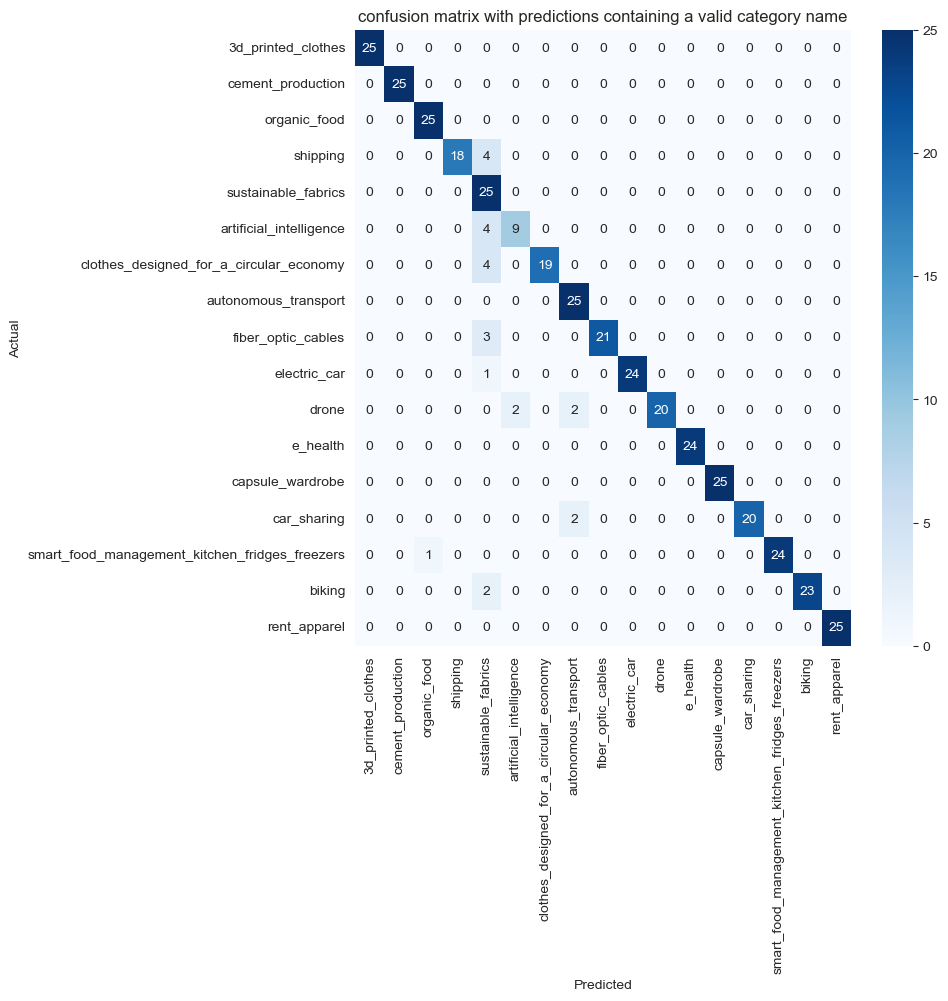

In [16]:
predictions_with_valid_category_name = predictions[predictions.prediction_after_processing.isin(annotated_categories)]
plot_confusion_matrix(predictions_with_valid_category_name, title="confusion matrix with predictions containing a valid category name")